# Fuzzy com MLP

Multilayer Perceptron com lógica Fuzzy.

In [4]:
import numpy as np
from sklearn import datasets
from sklearn import preprocessing

import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

## Aplicando Fuzzy aos valores de entrada

Precisamos fuzzyficar cada atributo para obter o grau de pertinencia de cada característica as classes do conjunto de dados IRIS.

Para criar esse range e as faixas de pertinencia foi utilizando a transformação gaussiana.


In [5]:
iris = datasets.load_iris()
dados = iris.data

## Normalizando as entradas

In [6]:
preprocessar = preprocessing.MinMaxScaler()
entrada = preprocessar.fit_transform(dados)

## Calculando o range, média e desvio padrão de cada classe

In [22]:
universo = np.arange(0, 1, 0.01)
media_setosa = np.mean(entrada[0:50,:])
desvio_setosa = np.std(entrada[0:50,:])
media_versicolor = np.mean(entrada[50:100,:])
desvio_versicolor = np.std(entrada[50:100,:])
media_virginica = np.mean(entrada[100:150,:])
desvio_virginica = np.std(entrada[100:150,:])

## Aplicando a transformação gaussiana

C:\ProgramData\Anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


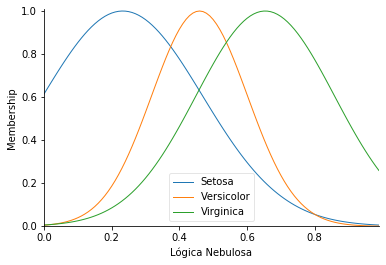

In [24]:
fuzzy = ctrl.Antecedent(universo, 'Lógica Nebulosa')
fuzzy['Setosa'] = fuzz.gaussmf(universo, media_setosa, desvio_setosa)
fuzzy['Versicolor'] = fuzz.gaussmf(universo, media_versicolor, desvio_versicolor)
fuzzy['Virginica'] = fuzz.gaussmf(universo, media_virginica, desvio_virginica)
fuzzy.view()
plt.show()

## Fuzzificando as entradas

Criando um funcao para passar uma amostra da base de dados e cada atributo da amostra vai virar 3 atributos (o grau de pertinecia a cada uma das 3 classes)

In [9]:
def fuzzying(vetor):
    retorno = []
    for i in range(len(vetor)):
        retorno.append(fuzz.interp_membership(universo, fuzz.gaussmf(universo, media_setosa, desvio_setosa), vetor[i]))
        retorno.append(fuzz.interp_membership(universo, fuzz.gaussmf(universo, media_versicolor, desvio_versicolor), vetor[i]))
        retorno.append(fuzz.interp_membership(universo, fuzz.gaussmf(universo, media_virginica, desvio_virginica), vetor[i]))
    return np.asarray(retorno).T

## Utilizando a função

In [10]:
fuzzying([0.2, 0.56, 0.3, 0.8])

array([0.99051683, 0.18656282, 0.08544104, 0.38156028, 0.77825999,
       0.90014951, 0.95995498, 0.53004173, 0.22417374, 0.05538159,
       0.0558928 , 0.77485862])

## Utilizando MLP do scikit-learn

In [11]:
def gerar_mlp(neuronios, taxa_aprendizado, max_iteracoes):
    mlp = MLPRegressor(
        solver='adam',
        hidden_layer_sizes=(neuronios,),
        random_state=1,
        learning_rate='constant',
        learning_rate_init=taxa_aprendizado,
        max_iter=max_iteracoes,
        activation='logistic',
        momentum=0.1
    )
    return mlp

## Tratando o cojunto de dados

Fuzzyficacao das entradas para transformar 4 atributos em 12

In [12]:
entradas_fuzzy = []
for i in range(150):
    entradas_fuzzy.append(fuzzying(entrada[i,:]))

entradas_fuzzy = np.asarray(entradas_fuzzy)
entradas_fuzzy

array([[0.99888464, 0.24582622, 0.10815221, ..., 0.72070721, 0.01293171,
        0.01139786],
       [0.96155383, 0.11813537, 0.05881794, ..., 0.72070721, 0.01293171,
        0.01139786],
       [0.87579739, 0.04860745, 0.02968443, ..., 0.72070721, 0.01293171,
        0.01139786],
       ...,
       [0.27592919, 0.56489911, 0.9783073 , ..., 0.06029081, 0.06435886,
        0.7969984 ],
       [0.45698576, 0.89059029, 0.82700008, ..., 0.01493339, 0.00554178,
        0.43836686],
       [0.66799125, 0.99364443, 0.59233276, ..., 0.13084121, 0.2145719 ,
        0.96502527]])

## Transformando o vetor de saida

Mudando de [-1,0,1] em [0,0.5,1]

In [13]:
saida = np.arange(150, dtype=float)
for i in range(150):
    if i <50:
        saida[i] = 0
    if 50 <= i < 100:
        saida[i] = 0.5
    if 100 <= i < 150:
        saida[i] = 1
saida = saida.reshape(150,1)

## Criando a saída do modelo MLP

Como o objetivo aqui eh que a saida da MLP seja fuzzy tambem, uma vez que teremos 1 unico neuronio de saida (dando uma resposta numerica, assim como uma regressao), precisamos de um especialista para indicar as faixas de resposta para cada classe:

In [25]:
def obter_classe(respostas, valor_menor, valor_maior):
    label_previsto = []
    for i in respostas:
        if i < valor_menor:
            label_previsto.append('Setosa')
        elif i >= valor_menor and i <= valor_maior:
            label_previsto.append('Versicolor')
        else:
            label_previsto.append('Virginica')
    return label_previsto

## Função mapear as saidas

Mudando a saídas de [0,0.5,1] para ['Setosa', 'Versicolor', 'Virginica']

In [15]:
def traduz_saida(saidas):
    resposta = []
    for i in saidas:
        if i == 0:
            resposta.append('Setosa')
        elif i == 0.5:
            resposta.append('Versicolor')
        else:
            resposta.append('Virginica')
    return resposta

## Aplicando o MLP

Utilizando uma validação cruzada de tamanho 3 e imprimindo o relatorio de desempenho de cada interação:

In [16]:
skf = StratifiedShuffleSplit(n_splits=3, test_size=0.25)    
for train_idx, test_idx in skf.split(entradas_fuzzy,saida.ravel()):
    x_treinamento = entradas_fuzzy[train_idx]
    y_treinamento = saida[train_idx]
    x_teste = entradas_fuzzy[test_idx]
    y_teste = saida[test_idx]
    mlp = gerar_mlp(20, 0.01, 100)
    mlp.fit(x_treinamento, y_treinamento.ravel())
    previsao = obter_classe(mlp.predict(x_teste), 0.25, 0.8)
    print('######################################################')
    print(classification_report(traduz_saida(y_teste), previsao))


######################################################
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        13
  Versicolor       0.83      0.83      0.83        12
   Virginica       0.85      0.85      0.85        13

    accuracy                           0.89        38
   macro avg       0.89      0.89      0.89        38
weighted avg       0.89      0.89      0.89        38

######################################################
              precision    recall  f1-score   support

      Setosa       0.92      0.92      0.92        12
  Versicolor       0.85      0.85      0.85        13
   Virginica       0.92      0.92      0.92        13

    accuracy                           0.89        38
   macro avg       0.90      0.90      0.90        38
weighted avg       0.89      0.89      0.89        38

######################################################
              precision    recall  f1-score   support

      Setosa      